## Training with fitzpatrick

In [36]:
from sklearn.model_selection import train_test_split

import pandas as pd

from pathlib import Path
from PIL import Image

from torchvision import transforms

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision

from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
import torch

#### 1. Preprocesing

In [81]:
# 1. Set the data directory
# 2. Preprocessing to the initial data
# Drop -1 skin tone, class non-neoplastic, int malign and skin_tone_map
fitzpatrick_df = pd.read_csv("/shared/BIOE589/siemens/Jhersin_Code/CS543-ECE549/Classification/csv/fitzpatrick17k_downloaded.csv")
fitzpatrick_df = fitzpatrick_df[(fitzpatrick_df["fitzpatrick_scale"] >= 0)].copy()
fitzpatrick_df = fitzpatrick_df[fitzpatrick_df["three_partition_label"] != "non-neoplastic"]
fitzpatrick_df["malignant"] = (fitzpatrick_df["three_partition_label"] == "malignant").astype(int)
skin_tone_map = {
    1: 12, 2: 12,
    3: 34, 4: 34,
    5: 56, 6: 56,
}
fitzpatrick_df["skin_tone"] = fitzpatrick_df["fitzpatrick_scale"].map(skin_tone_map).astype(int)

benign_count = (fitzpatrick_df["three_partition_label"] == "benign").sum()
malignant_count = (fitzpatrick_df["three_partition_label"] == "malignant").sum()

print(f'Classes after remove non-neoplastic :  {fitzpatrick_df["three_partition_label"].unique()}\nLen after remove non-neoplastic : {len(fitzpatrick_df)}')
print(f'benign_count {benign_count} malignant_count {malignant_count}')
print(f'Classes skin_tone :  {fitzpatrick_df["skin_tone"].unique()}')
print(f'Fitzpatrick_df.head():')
fitzpatrick_df.head()

Classes after remove non-neoplastic :  ['benign' 'malignant']
Len after remove non-neoplastic : 3273
benign_count 1789 malignant_count 1484
Classes skin_tone :  [12 56 34]
Fitzpatrick_df.head():


,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,malignant,skin_tone
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,0,12
5,45f7fe0e10214e32e890cad9d29d4811,6,5,kaposi sarcoma,malignant dermal,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpickkapos...,1,56
13,b87804452f60aa162a6d29c0f66a2466,2,1,melanoma,malignant melanoma,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicLlmmlm...,1,12
18,4c3f795cf8eb72b946f9bd2642cf23c1,6,5,melanoma,malignant melanoma,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmmelan...,1,56
19,99247c9fe486aa9ab71686c8e676c135,2,1,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,0,12


#### 2. Prepare Dataset and Dataloader

In [82]:
# 2.0 Custom dataset
class FitzDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = ['Benign', 'Malignant']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = "/shared/BIOE589/siemens/Jhersin_Code/CS543-ECE549/Classification/data/" + row["md5hash"] + ".jpg"
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        label = int(row["malignant"])# 1 for malignant, 0 for benign
        return img, label

# 2.1 train validation split
df = fitzpatrick_df.copy()
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["malignant"],
    random_state=543
)

# 2.2 DataLoader
image_size = 224
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.6, 1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
])

batch_size = 32

train_dataset = FitzDataset(train_df, transform=train_transform)
val_dataset = FitzDataset(val_df, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print("train:", len(train_df), "val:", len(val_df))
for X,y in val_loader:
    print(f'Train Dataloder X: {X.shape}, Test DataLoader y: {y.shape}')
    break

train: 2618 val: 655
Train Dataloder X: torch.Size([32, 3, 224, 224]), Test DataLoader y: torch.Size([32])


In [83]:
train_benign_count = (train_df["three_partition_label"] == "benign").sum()
train_malignant_count = (train_df["three_partition_label"] == "malignant").sum()
print(f'train_benign_count {train_benign_count}, train_malignant_count {train_malignant_count}')

train_benign_count 1431, train_malignant_count 1187


In [54]:
# img_augmented, label_augmented = next(iter(train_loader))
#
# plt.figure(figsize = (10,10))
# for i in range(9):
#     plt.subplot(3,3,i+1)
#     plt.imshow(img_augmented[i].permute(1,2,0))
#     plt.title(f'Label : {label_augmented[i].item()}')
#     plt.axis(False)

#### 3. Training

In [65]:
def train_model(model, criterion, optimizer, train_loader, test_loader, device, num_epochs):
    """
    Trains and validates a machine learning model using a specified training and validation (test) dataset.

    Parameters:
    - model: The neural network model to be trained and evaluated.
    - criterion: The loss function used to evaluate the performance of the model.
    - optimizer: The optimization algorithm used to update the model's weights.
    - train_loader: DataLoader for the training dataset. Provides batches of data for the training phase.
    - test_loader: DataLoader for the validation (test) dataset. Used for evaluating the model.
    - device: The device to use for computation (e.g., 'cuda:0' or 'cpu').
    - num_epochs: The number of epochs (iterations over the entire dataset) to train the model.

    Returns:
    - history: A dictionary containing 'train_loss', 'train_accuracy', 'train_recall', 'train_precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'.
      These metrics are tracked for each epoch.
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_recall': [],
        'train_precision': [],
        'train_f1' : [],
        'val_loss': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_precision': [],
        'val_f1' : []
    }
    # Initialize the scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

    # Initialize tracking for best model
    best_val_accuracy = 0.0
    os.makedirs('models', exist_ok=True)

    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs}, Current LR: {current_lr:.8f}')
        # Train the model
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        train_prediction, train_ground_truth = [], []
        for images_train, labels_train in train_loader:
            images_train, labels_train = images_train.to(device), labels_train.to(device)
            outputs_train = model(images_train)
            loss_train = criterion(outputs_train, labels_train)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            train_loss += loss_train.item()
            _, predicted_train = torch.max(outputs_train, 1)
            total_train += labels_train.size(0)
            correct_train += (predicted_train == labels_train).sum().item()
            train_prediction.extend(predicted_train.view(-1).cpu().numpy())
            train_ground_truth.extend(labels_train.view(-1).cpu().numpy())
        train_accuracy = correct_train / total_train
        train_recall = recall_score(train_ground_truth, train_prediction, average = 'macro')
        train_precision = precision_score(train_ground_truth, train_prediction, average = 'macro', zero_division = 1)
        train_f1 = f1_score(train_ground_truth, train_prediction, average = 'macro')

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_predictions = []
        val_ground_truth = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.view(-1).cpu().numpy())
                val_ground_truth.extend(labels.view(-1).cpu().numpy())
        val_accuracy = correct / total
        val_recall = recall_score(val_ground_truth, val_predictions, average='macro')
        val_precision = precision_score(val_ground_truth, val_predictions, average='macro', zero_division=1)
        val_f1 = f1_score(val_ground_truth, val_predictions, average='macro')

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'models/best_model_ViT_Jhersin.pth')

        #Update the learning rate
        scheduler.step()

        # Epoch summary
        print(f'Train loss: {train_loss/len(train_loader):.4f} - accuracy: {train_accuracy:.4f} - recall: {train_recall:.4f} - precision: {train_precision:.4f} - f1_score: {train_f1:.4f}')
        print(f'Val loss: {val_loss/len(test_loader):.4f} - accuracy: {val_accuracy:.4f} - recall: {val_recall:.4f} - precision: {val_precision:.4f} -f1_score: {val_f1:.4f}')

        # Append history
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_accuracy'].append(train_accuracy)
        history['train_recall'].append(train_recall)
        history['train_precision'].append(train_precision)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)
        history['val_recall'].append(val_recall)
        history['val_precision'].append(val_precision)
        history['val_f1'].append(val_f1)

    return history

In [66]:
def plot_training_results(history, model, test_loader, device):

    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_accuracy'], label = 'train accuracy')
    plt.plot(history['val_accuracy'], label = 'val accuracy')
    plt.title(f'Accuracy for model : {model.__class__.__name__}')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label = 'train loss')
    plt.plot(history['val_loss'], label = 'val_loss')
    plt.title(f'Loss for model : {model.__class__.__name__}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    model.eval()
    with torch.inference_mode():
        list_labels_test, list_predicted_test = [], []
        for images_test, labels_test in test_loader:
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            outputs_test = model(images_test)
            _, predicted_test = torch.max(outputs_test, 1)
            list_labels_test.extend(labels_test.view(-1).cpu().numpy())
            list_predicted_test.extend(predicted_test.view(-1).cpu().numpy())

     # Calculate confusion matrix using sklearn
    cm = confusion_matrix(list_labels_test, list_predicted_test)

    # Determine number of classes
    num_classes = len(np.unique(list_labels_test))

    # Define class names for binary classification
    if num_classes == 2:
        class_names = ['Benign', 'Malignant']
    else:
        class_names = [f'Class {i}' for i in range(num_classes)]

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f'Confusion Matrix - {model.__class__.__name__}', fontsize=14, pad=15)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(3)

# # 3.1 Model RestNet18
# # 1. Get pretrained weights
# pretrained_resnet_weights = models.ResNet18_Weights.IMAGENET1K_V1
# # 2. Set up the pretrained weights
# model = models.resnet18(weights=pretrained_resnet_weights)
# # 3. Freeze the base parameters
# for parameter in model.parameters():
#     parameter.requires_grad = False
# # 4. Change the classifier head
# in_features = model.fc.in_features
# model.fc = nn.Linear(in_features, 2).to(device)
# # 5. Get automatic transforms from pretrained ViT weights
# pretrained_resnet_transforms = pretrained_resnet_weights.transforms()
# #print(pretrained_resnet_transforms)

# 3.1 ViT model
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# 2. Setup a ViT model instance with pretrained weights
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
# 3. Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False
# 4. Change the classifier head
model.heads = nn.Linear(in_features=768, out_features=2).to(device)
# 5. Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()

# 3.2 Optimizer and loss

class FocalLossMulticlass(nn.Module):
    def __init__(self, alpha, gamma=2, reduction='mean'):
        super(FocalLossMulticlass, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        """
        Multi-class focal loss using CrossEntropyLoss.
        - inputs: raw logits from the model (batch_size x num_classes)
        - targets: true class labels (batch_size), integer values
        """
        device = targets.device
        alpha = self.alpha.to(device)

        ce_loss = self.ce_loss(inputs, targets)  # Standard CE loss (no reduction)
        pt = torch.exp(-ce_loss)  # pt = softmax probability of the true class
        focal_loss = alpha[targets] * (1 - pt) ** self.gamma * ce_loss

        return focal_loss.mean()


alpha = torch.tensor([0.55, 0.45])
gamma = 3.0
criterion_focal = FocalLossMulticlass(alpha = alpha, gamma = gamma, reduction = 'mean')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=7e-4)

In [72]:
num_epochs = 15
device = "cuda:3"
history_normal_CE = train_model(model, criterion_focal, optimizer, train_loader, val_loader, device, num_epochs)

Epoch 1/15, Current LR: 0.00100000
Train loss: 0.0599 - accuracy: 0.6551 - recall: 0.6470 - precision: 0.6518 - f1_score: 0.6475
Val loss: 0.0534 - accuracy: 0.6733 - recall: 0.6509 - precision: 0.7018 -f1_score: 0.6408
Epoch 2/15, Current LR: 0.00098907
Train loss: 0.0512 - accuracy: 0.7032 - recall: 0.6950 - precision: 0.7024 - f1_score: 0.6962
Val loss: 0.0485 - accuracy: 0.7176 - recall: 0.7098 - precision: 0.7172 -f1_score: 0.7111
Epoch 3/15, Current LR: 0.00095677
Train loss: 0.0479 - accuracy: 0.7311 - recall: 0.7237 - precision: 0.7310 - f1_score: 0.7252
Val loss: 0.0498 - accuracy: 0.7237 - recall: 0.7085 - precision: 0.7384 -f1_score: 0.7084
Epoch 4/15, Current LR: 0.00090451
Train loss: 0.0464 - accuracy: 0.7490 - recall: 0.7420 - precision: 0.7495 - f1_score: 0.7437
Val loss: 0.0533 - accuracy: 0.6992 - recall: 0.6798 - precision: 0.7236 -f1_score: 0.6753
Epoch 5/15, Current LR: 0.00083457
Train loss: 0.0463 - accuracy: 0.7536 - recall: 0.7471 - precision: 0.7537 - f1_score

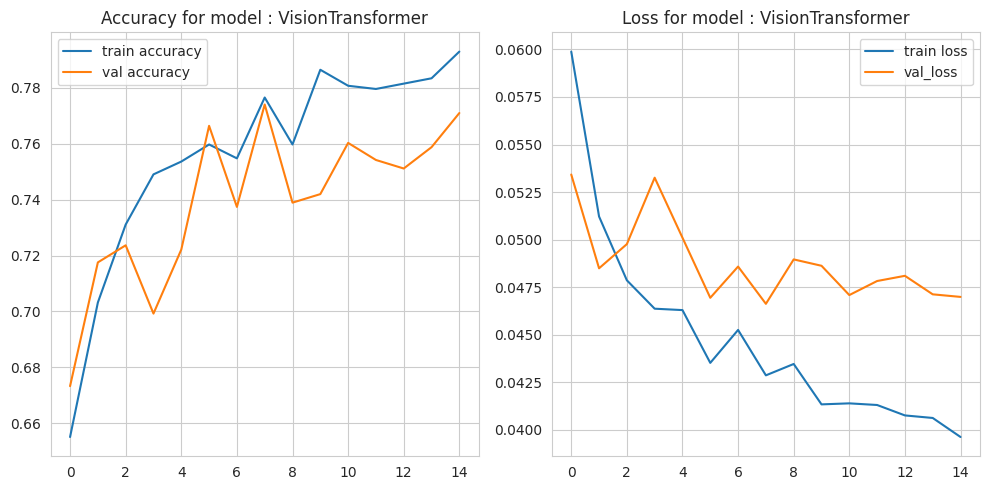

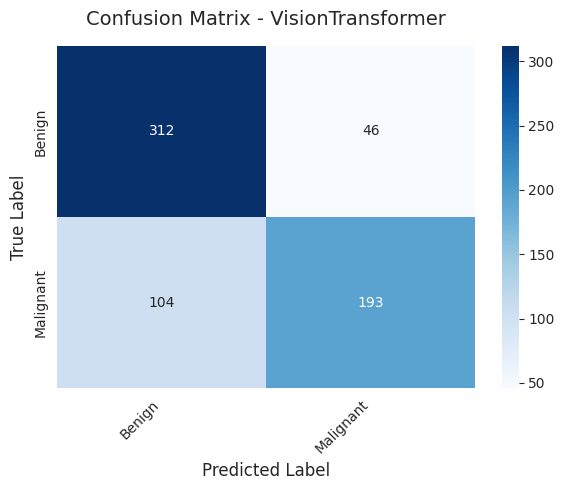

In [73]:
plot_training_results(history_normal_CE, model, val_loader, device)

## Test with DDI dataset

### Preprocesing

In [74]:
ddi_df = pd.read_csv("/shared/BIOE589/siemens/Jhersin_Code/CS543-ECE549/Classification/data_ddi/ddi_metadata.csv")
DDI_IMG_DIR = Path("/shared/BIOE589/siemens/Jhersin_Code/CS543-ECE549/Classification/data_ddi")

#
ddi_df["img_path"] = ddi_df["DDI_file"].apply(lambda fn: str(DDI_IMG_DIR / fn))
ddi_df = ddi_df[ddi_df["img_path"].apply(lambda p: Path(p).is_file())].copy()

image_size = 224
basic_tf = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

class DdiDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        label = int(row["malignant"])
        tone = row["skin_tone"]
        return img, label, tone

ddi_loader = DataLoader(
    DdiDataset(ddi_df, transform=val_transform),
    batch_size=64,
    shuffle=False,
    num_workers=4,
)
print("DDI counts：", len(ddi_df))

DDI counts： 656


### Evaluation


OVERALL EVALUATION ON DDI DATASET
ACC = 0.6357, F1 = 0.3949, AUC = 0.5929
Total samples: 656


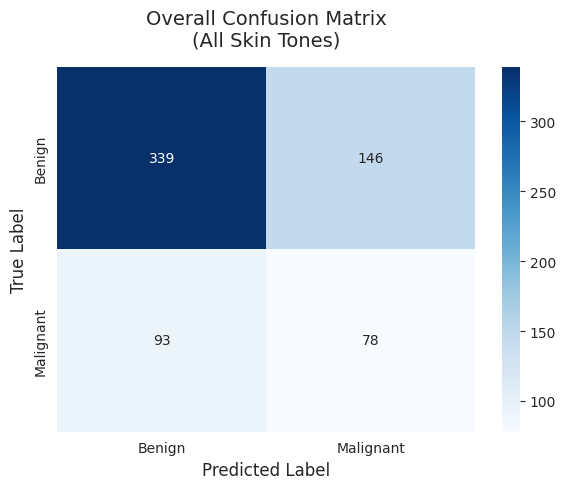


Overall Classification Report:
              precision    recall  f1-score   support

      Benign       0.78      0.70      0.74       485
   Malignant       0.35      0.46      0.39       171

    accuracy                           0.64       656
   macro avg       0.57      0.58      0.57       656
weighted avg       0.67      0.64      0.65       656


PERFORMANCE BY SKIN TONE GROUP

--- Light (I-II) (Group 12) ---
  n = 208
  ACC = 0.5913, F1 = 0.3885, AUC = 0.6437
  Class distribution: Benign=159, Malignant=49

--- Medium (III-IV) (Group 34) ---
  n = 241
  ACC = 0.6598, F1 = 0.4875, AUC = 0.6684
  Class distribution: Benign=167, Malignant=74

--- Dark (V-VI) (Group 56) ---
  n = 207
  ACC = 0.6522, F1 = 0.2500, AUC = 0.4235
  Class distribution: Benign=159, Malignant=48


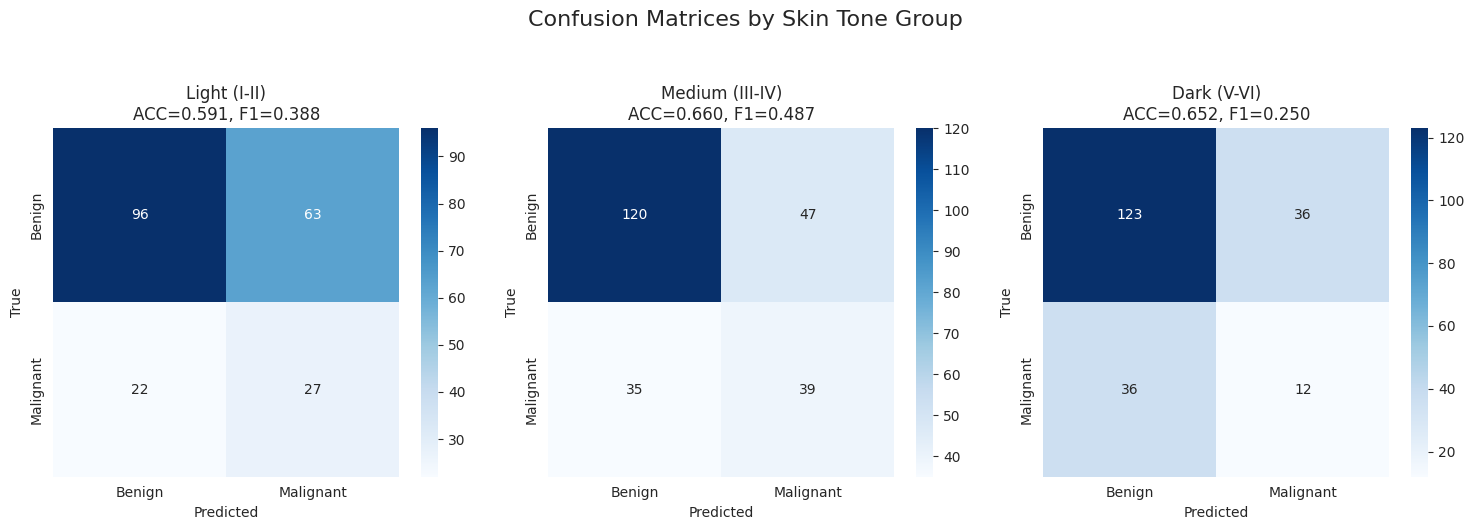

In [75]:
def eval_on_ddi_with_confusion(model, loader, device):
    """
    Evaluate model on DDI dataset with confusion matrices per skin tone group.
    """
    model.eval()
    all_probs = []
    all_labels = []
    all_tones = []

    # Collect predictions
    for imgs, labels, tones in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]

        all_probs.append(probs.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())
        all_tones.append(tones.numpy())

    # Concatenate all batches
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    all_tones = np.concatenate(all_tones)

    # Overall metrics
    y_pred = (all_probs >= 0.5).astype(int)
    acc = accuracy_score(all_labels, y_pred)
    f1 = f1_score(all_labels, y_pred)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float("nan")

    print("\n" + "="*60)
    print("OVERALL EVALUATION ON DDI DATASET")
    print("="*60)
    print(f"ACC = {acc:.4f}, F1 = {f1:.4f}, AUC = {auc:.4f}")
    print(f"Total samples: {len(all_labels)}")

    # Overall confusion matrix
    cm_overall = confusion_matrix(all_labels, y_pred)

    # Plot overall confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f'Overall Confusion Matrix\n(All Skin Tones)', fontsize=14, pad=15)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print overall classification report
    print("\nOverall Classification Report:")
    print(classification_report(all_labels, y_pred, target_names=['Benign', 'Malignant']))

    # Evaluate per skin tone group
    skin_tone_groups = [12, 34, 56]
    tone_labels = {12: "Light (I-II)", 34: "Medium (III-IV)", 56: "Dark (V-VI)"}

    print("\n" + "="*60)
    print("PERFORMANCE BY SKIN TONE GROUP")
    print("="*60)

    # Create subplot for all confusion matrices
    fig, axes = plt.subplots(1, len(skin_tone_groups), figsize=(15, 5))
    if len(skin_tone_groups) == 1:
        axes = [axes]

    for idx, tone_value in enumerate(skin_tone_groups):
        mask = (all_tones == tone_value)
        if mask.sum() == 0:
            print(f"No samples for skin tone group {tone_value}")
            continue

        # Get data for this skin tone group
        probs_t = all_probs[mask]
        labels_t = all_labels[mask]
        y_pred_t = (probs_t >= 0.5).astype(int)

        # Calculate metrics
        acc_t = accuracy_score(labels_t, y_pred_t)
        f1_t = f1_score(labels_t, y_pred_t)

        try:
            auc_t = roc_auc_score(labels_t, probs_t)
        except ValueError:
            auc_t = float("nan")

        # Calculate confusion matrix
        cm_t = confusion_matrix(labels_t, y_pred_t)

        # Print metrics
        print(f"\n--- {tone_labels[tone_value]} (Group {tone_value}) ---")
        print(f"  n = {mask.sum()}")
        print(f"  ACC = {acc_t:.4f}, F1 = {f1_t:.4f}, AUC = {auc_t:.4f}")

        # Print classification report
        print(f"  Class distribution: Benign={(labels_t == 0).sum()}, Malignant={(labels_t == 1).sum()}")

        # Plot confusion matrix for this skin tone
        ax = axes[idx]
        sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'])
        ax.set_title(f'{tone_labels[tone_value]}\nACC={acc_t:.3f}, F1={f1_t:.3f}', fontsize=12)
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('True', fontsize=10)

    plt.suptitle('Confusion Matrices by Skin Tone Group', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

    # Return all results for further analysis
    results = {
        'overall': {
            'probs': all_probs,
            'labels': all_labels,
            'preds': y_pred,
            'accuracy': acc,
            'f1': f1,
            'auc': auc,
            'confusion_matrix': cm_overall
        },
        'by_tone': {}
    }

    # Store per-tone results
    for tone_value in skin_tone_groups:
        mask = (all_tones == tone_value)
        if mask.sum() > 0:
            results['by_tone'][tone_value] = {
                'probs': all_probs[mask],
                'labels': all_labels[mask],
                'preds': (all_probs[mask] >= 0.5).astype(int),
                'count': mask.sum()
            }

    return results

# Usage
results = eval_on_ddi_with_confusion(model, ddi_loader, device)